In [1]:

%matplotlib widget

ValueError: Key backend: 'module://ipympl.backend_nbagg' is not a valid value for backend; supported values are ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template', 'inline']

# Non-Realistic Object Stylization
> Paper Review

In [2]:
#| default_exp core

In [3]:
#| hide
from nbdev.showdoc import *

In [4]:
#| export
import trimesh
import scipy
import pyglet
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

## Overview

The paper describes a method for creating stylized geometry for pre-segmented input models.
It uses an initial shape analysis step to find the type of fill pattern and its orientation to be used.
In an interactive process the user can then choose a fill pattern for each segment.
In a clipping stage the fill pattern is then clipped against the model boundary and all segments are assembled into a complete model.

### Shape Analysis

The shape analysis is the most interesting part here, it consists of **Random Sample Consensus (RANSAC)**, which helps to determine the best-fitting primitive shape such as a box-, ellipsoid- or a cone-like structure. It uses a limited amount of vertex samples per iteration to find a primitive shape that is most similar to the shape of the segment.

 **Principal Component Analysis (PCA)** is to determine the axes of maximum variance of the vertex coordinates and computes 3 main axes as well as the ratio of variance between these. This allows to orient the primitives that are fit to the model and help select an appropriate fill pattern.

When both methods are combined good selections for fill patterns can be made that can also be oriented and distributed optimally within the model.


![pca-ransac.png](data/pca-ransac.png)

Schematic diagram from the paper that shows the outcome of RANSAC and PCA. While the input mesh is given on the left, the center illustrates the shapes detected with RANSAC and the right-hand side points out the main directions of PCA for each segment.


## Implementation

In this notebook I implement a demonstration of each of these methods on an input model and then combine both of them to get similar results to those in the paper.


### Primitive Fitting with RANSAC


To implement RANSAC for shape fitting we need to be able to load a model.

We also need shapes to fit to the model.



In [5]:
# load model 

model1 = "data/armor griffin.glb"
model2 = "data/big_soviet_panel_house_lowpoly.glb"
model3 = "data/1967 Chevrolet Camaro SS.glb"
model4 = "data/1956 BMW Isetta 300 Convertible.glb"
default = "Box.glb"
scene = trimesh.Scene()

shapes = []

number_of_points = 6
inlier_threshold = 0.1
number_of_trials = 10

#trimesh.util.attach_to_log()

mesh = trimesh.load(default, force='mesh')
scene.add_geometry(mesh)

'Mesh'

In [6]:
mesh.show()

In [7]:
type(mesh)

trimesh.base.Trimesh

In [8]:
mesh.is_watertight

False

In [9]:

vertices = np.array(mesh.vertices)
vertices

array([[-0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5],
       [-0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5,  0.5],
       [-0.5,  0.5,  0.5],
       [ 0.5, -0.5,  0.5],
       [-0.5, -0.5,  0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5,  0.5],
       [ 0.5, -0.5, -0.5],
       [ 0.5, -0.5,  0.5],
       [-0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [-0.5, -0.5, -0.5],
       [ 0.5, -0.5, -0.5],
       [-0.5,  0.5,  0.5],
       [-0.5,  0.5, -0.5],
       [-0.5, -0.5,  0.5],
       [-0.5, -0.5, -0.5],
       [-0.5, -0.5,  0.5],
       [-0.5, -0.5, -0.5],
       [ 0.5, -0.5,  0.5],
       [ 0.5, -0.5, -0.5]])

In [10]:
#| export
def ransac_bounding_box(points, n_trials=10, sample_size=6, threshold=0.01):
    best_fit = None
    best_inliers = 0

    for i in range(n_trials):
        sample_indices = np.random.choice(len(points), sample_size, replace=False)
        sample = points[sample_indices]

        # Create bounding box
        min_corner = sample.min(axis=0)
        max_corner = sample.max(axis=0)
        
        # Count inliers
        in_box = np.all((points >= min_corner - threshold) & (points <= max_corner + threshold), axis=1)
        num_inliers = np.count_nonzero(in_box)

        if num_inliers > best_inliers:
            best_inliers = num_inliers
            best_fit = (min_corner, max_corner)

    return best_fit, best_inliers


In [11]:
# |export 
def ransac_cylinder_with_pca(points, n_trials=1000, threshold=0.05):
    # --- Step 1: PCA Initialization ---
    pca = PCA(n_components=3)
    pca.fit(points)
    axis = pca.components_[0]
    center = pca.mean_

    # Project points onto the axis
    projections = np.dot(points - center, axis)
    min_proj, max_proj = projections.min(), projections.max()
    height = max_proj - min_proj
    base_point = center + min_proj * axis  # point on axis

    # --- Step 2: RANSAC for radius ---
    best_fit = None
    best_inliers = 0

    for _ in range(n_trials):
        sample = points[np.random.choice(len(points), 3, replace=False)]

        # Project sample to axis to get radial vectors
        v = sample - base_point
        sample_proj = np.dot(v, axis)
        closest_points = np.outer(sample_proj, axis) + base_point
        radial_vecs = sample - closest_points
        radius = np.mean(np.linalg.norm(radial_vecs, axis=1))

        # Evaluate all points
        v_all = points - base_point
        projections_all = np.dot(v_all, axis)
        closest_points_all = np.outer(projections_all, axis) + base_point
        radial_vectors = points - closest_points_all
        dists = np.linalg.norm(radial_vectors, axis=1)

        inliers = np.abs(dists - radius) < threshold
        num_inliers = np.sum(inliers)

        if num_inliers > best_inliers:
            best_inliers = num_inliers
            best_fit = {
                "point_on_axis": base_point,
                "axis_direction": axis,
                "radius": radius,
                "height": height,
            }

    return best_fit, best_inliers



In [12]:
#| export

def trimesh_scene_with_box(mesh, fit_box):
    min_corner, max_corner = fit_box
    center = (min_corner + max_corner) / 2
    extents = max_corner - min_corner

    # Create transparent box
    box = trimesh.creation.box(extents=extents,
                               transform=trimesh.transformations.translation_matrix(center))
    box.visual.face_colors = [255, 0, 0, 100]  # Semi-transparent red

    scene = trimesh.Scene()
    scene.add_geometry(mesh)
    scene.add_geometry(box)
    scene.show()
    return scene

In [13]:
#|export

def trimesh_scene_with_sphere(mesh, fit_sphere):
    center, radius = fit_sphere

    # Create a semi-transparent green sphere
    sphere = trimesh.creation.icosphere(radius=radius, subdivisions=4)
    sphere.apply_translation(center)
    sphere.visual.face_colors = [0, 255, 0, 100]  # Semi-transparent green

    # Build scene
    scene = trimesh.Scene()
    scene.add_geometry(mesh)
    scene.add_geometry(sphere)
    scene.show()
    return scene


In [14]:
#| export
def trimesh_scene_with_cylinder(mesh, fit_cylinder, height=None):
    origin = fit_cylinder["point_on_axis"]
    direction = fit_cylinder["axis_direction"]
    radius = fit_cylinder["radius"]

    # Estimate height if not given
    bbox = mesh.bounds
    if height is None:
        height = np.linalg.norm(bbox[1] - bbox[0])  # loose approximation

    # Create base cylinder aligned with Z axis
    cylinder = trimesh.creation.cylinder(radius=radius, height=height, sections=32)
    cylinder.visual.face_colors = [0, 0, 255, 100]  # semi-transparent blue

    # Align cylinder's Z axis with direction
    z_axis = np.array([0, 0, 1])
    axis = direction / np.linalg.norm(direction)
    align = trimesh.geometry.align_vectors(z_axis, axis)

    # Translate to position: center along axis starting from origin
    translation = trimesh.transformations.translation_matrix(origin + 0.5 * height * axis)

    # Combine rotation and translation
    transform = trimesh.transformations.concatenate_matrices(translation, align)
    cylinder.apply_transform(transform)

    # Show scene
    scene = trimesh.Scene()
    scene.add_geometry(mesh)
    scene.add_geometry(cylinder)
    scene.show()
    return scene



In [15]:
#| export

def run_ransac_fits(points, threshold=0.01, n_trials=1000):
    fits = {}
    
    bbox_fit, bbox_inliers = ransac_bounding_box(points, threshold=threshold, n_trials=n_trials)
    fits['box'] = {'fit': bbox_fit, 'inliers': bbox_inliers}
    
    sphere_fit, sphere_inliers = ransac_sphere(points)
    fits['sphere'] = {'fit': sphere_fit, 'inliers': sphere_inliers}
    
    
    cylinder_fit, cylinder_inliers = ransac_cylinder_with_pca(points, threshold=threshold, n_trials=n_trials)
    fits["cylinder"] = {"fit": cylinder_fit, "inliers": cylinder_inliers}

    
    # TODO: cylinder, cone, etc.
    
    return fits


In [16]:
#| export
def ransac_sphere(points, n_trials=1000, sample_size=4, threshold=0.1):
    best_fit = None
    best_inliers = 0

    for _ in range(n_trials):
        sample = points[np.random.choice(len(points), sample_size, replace=False)]
        
        # Solve (x - cx)^2 + (y - cy)^2 + (z - cz)^2 = r^2
        A = np.hstack((2 * sample, np.ones((sample.shape[0], 1))))
        b = np.sum(sample**2, axis=1).reshape(-1, 1)
        
        try:
            x = np.linalg.lstsq(A, b, rcond=None)[0].flatten()
            center = x[:3]
            radius = np.sqrt(x[3] + np.sum(center**2))

            # Evaluate inliers
            dists = np.linalg.norm(points - center, axis=1)
            inliers = np.abs(dists - radius) < threshold
            num_inliers = np.sum(inliers)

            if num_inliers > best_inliers:
                best_inliers = num_inliers
                best_fit = (center, radius)
        except np.linalg.LinAlgError:
            continue

    return best_fit, best_inliers


In [17]:
# Run RANSAC
fits = run_ransac_fits(vertices, threshold=0.05, n_trials=500)
for name, result in fits.items():
    print(f"{name} fit: inliers={result['inliers']} ({(result['inliers']/len(mesh.vertices)*100):.4f}%, fit={result['fit']}")



box fit: inliers=24 (100.0000%, fit=(array([-0.5, -0.5, -0.5]), array([0.5, 0.5, 0.5]))
sphere fit: inliers=24 (100.0000%, fit=(array([-1.68471303e-16,  3.88578059e-16, -1.63371378e-16]), 0.8660254037844386)
cylinder fit: inliers=24 (100.0000%, fit={'point_on_axis': array([ 0. , -0.5,  0. ]), 'axis_direction': array([0., 1., 0.]), 'radius': 0.7071067811865476, 'height': 1.0}


In [18]:
trimesh_scene_with_box(mesh, fits['box']['fit']).show()

In [19]:
trimesh_scene_with_sphere(mesh, fits['sphere']['fit']).show()

In [20]:
trimesh_scene_with_cylinder(mesh, fits["cylinder"]["fit"]).show()



### Determining Orientation and Shape Dimensions using PCA



In [21]:
#| export

def analyze_pca(points):
    pca = PCA(n_components=3)
    pca.fit(points)
    axes = pca.components_
    variances = pca.explained_variance_ratio_
    return axes, variances

In [22]:
# Run PCA
pca_axes, pca_variances = analyze_pca(vertices)

print("PCA Axes:\n", pca_axes)
print("PCA Variance Ratios:\n", pca_variances)

PCA Axes:
 [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
PCA Variance Ratios:
 [0.33333333 0.33333333 0.33333333]


In [23]:
#| export


def set_axes_equal(ax):
    """Set 3D plot axes to equal scale."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = np.abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = np.abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = np.abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    max_range = max(x_range, y_range, z_range)

    ax.set_xlim3d([x_middle - max_range / 2, x_middle + max_range / 2])
    ax.set_ylim3d([y_middle - max_range / 2, y_middle + max_range / 2])
    ax.set_zlim3d([z_middle - max_range / 2, z_middle + max_range / 2])

In [24]:
#| export

def plot_mesh_with_pca_and_box(vertices, pca_axes, fit_box):
    # Inside the function, right after receiving vertices:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot mesh vertices
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], s=0.5, alpha=0.1, label="Vertices")

    # Plot PCA axes
    origin = np.mean(vertices, axis=0)
    colors = ['r', 'g', 'b']
    for i in range(3):
        axis = pca_axes[i]
        ax.quiver(*origin, *axis, length=0.3, color=colors[i], label=f"PCA Axis {i+1}")

    # Plot fitted box
    min_corner, max_corner = fit_box
    from itertools import product, combinations
    corners = np.array(list(product(*zip(min_corner, max_corner))))
    for start, end in combinations(corners, 2):
        if np.sum(np.abs(start - end) == np.abs(max_corner - min_corner)) == 1:
            ax.plot(*zip(start, end), color="k", linewidth=0.5)

    set_axes_equal(ax)
    ax.set_title("PCA & RANSAC Bounding Box Visualization")
    ax.legend()
    plt.tight_layout()
    plt.show()

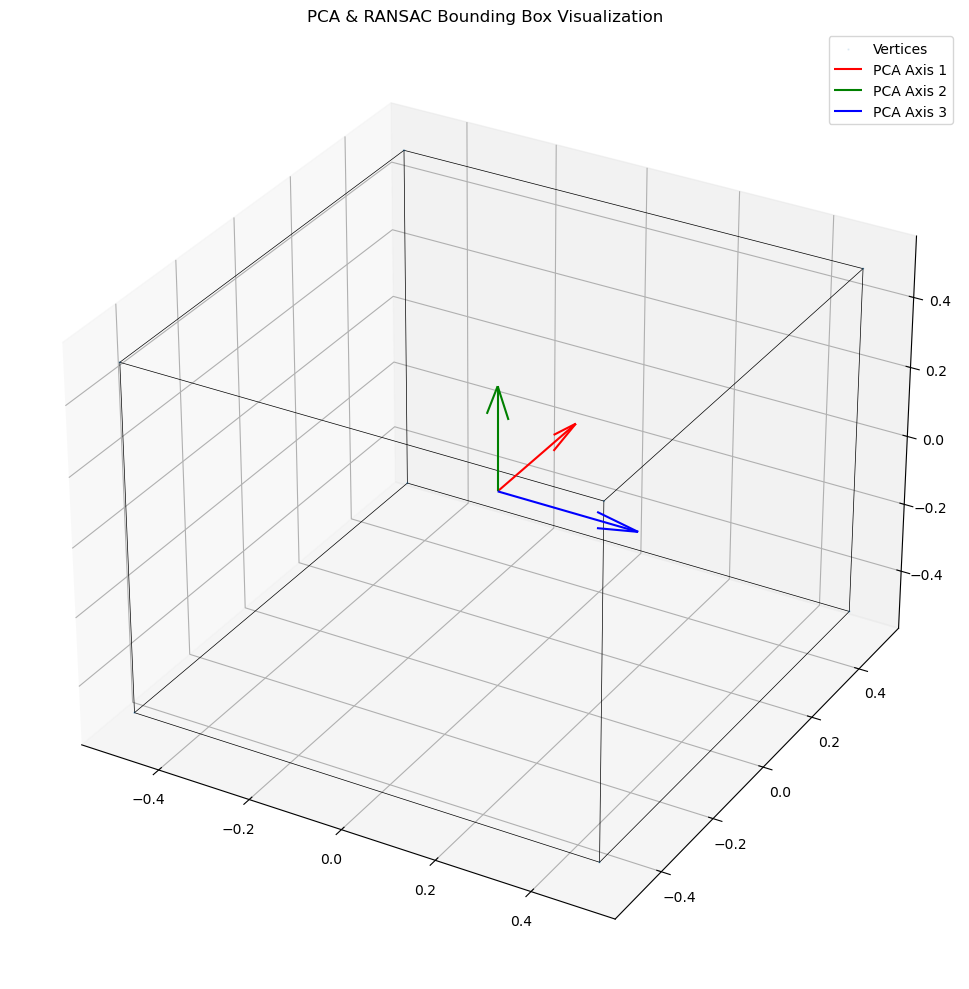

In [25]:
plot_mesh_with_pca_and_box(vertices, pca_axes, fits['box']['fit'])


In [26]:
#| hide
import nbdev; nbdev.nbdev_export()

ImportError: You must install black: `pip install black` if you wish to use black formatting with nbdev